# A CNN Mnist Model

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_05b_early_stopping")' FastaiNotebook_05b_early_stopping

Installing packages:
	.package(path: "/home/ubuntu/dev_swift/FastaiNotebook_05b_early_stopping")
		FastaiNotebook_05b_early_stopping
With SwiftPM flags: []
Working in: /tmp/tmpjx0ki_m_/swift-install
Updating https://github.com/latenitesoft/NotebookExport
Updating https://github.com/mxcl/Path.swift
Updating https://github.com/JustHTTP/Just
Completed resolution in 2.92s
Compile Swift Module 'FastaiNotebook_05b_early_stopping' (9 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


In [ ]:
//export
import Path
import TensorFlow
import Python

In [ ]:
import FastaiNotebook_05b_early_stopping

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Load data

In [ ]:
let data = mnistDataBunch(flat: false, bs: 512)

In [ ]:
let firstBatch = data.train.ds.first(where: { _ in true })!
let batchShape = firstBatch.xb.shape
let batchSize = batchShape.dimensions[0]
let exampleSideSize = batchShape.dimensions[1]
assert(exampleSideSize == batchShape.dimensions[2])
print("Batch size: \(batchSize)")
print("Example side size: \(exampleSideSize)")

let classCount = firstBatch.yb.shape.dimensions[0]
print("Class count: \(classCount)")

Batch size: 512
Example side size: 28
Class count: 512


In [ ]:
firstBatch.xb.shape

▿ TensorShape
  ▿ dimensions : 3 elements
    - 0 : 512
    - 1 : 28
    - 2 : 28


In [ ]:
// export
extension Learner {
    public class AddChannel: Delegate {
        public override func batchWillStart(learner: Learner) {
            learner.currentInput = learner.currentInput!.expandingShape(at: -1)
        }
    }
    
    public func makeAddChannel() -> AddChannel { return AddChannel() }
}

In [ ]:
//export 
public struct CnnModel: Layer {
    public var convs: [FAConv2D<Float>]
    public var pool = FAGlobalAvgPool2D<Float>()
    public var linear: FADense<Float>
    
    public init(channelIn: Int, nOut: Int, filters: [Int]){
        let allFilters = [channelIn] + filters
        convs = Array(0..<filters.count).map { i in
            return FAConv2D(allFilters[i], allFilters[i+1], ks: 3, stride: 2)
        }
        linear = FADense<Float>(filters.last!, nOut)
    }
    
    @differentiable
    public func call(_ input: TF) -> TF {
        return input.sequenced(through: convs, pool, linear)
    }
}

In [ ]:
let model = CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32])

In [ ]:
// Test that data goes through the model as expected.
let predictions = model(firstBatch.xb.expandingShape(at: -1))
print(predictions.shape)
print(predictions[0])

TensorShape(dimensions: [512, 10])
[   0.1119913,   0.05568877,  -0.06901221, 0.0023986027, -0.013684442,   0.06492978,
  0.014911912,  -0.12529324,  0.018024184,  -0.16360238]


# Compare training on CPU and GPU

In [ ]:
func optFunc(_ model: CnnModel) -> SGD<CnnModel> { return SGD(for: model, learningRate: 0.4)}
func modelInit() -> CnnModel { return CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32]) }
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

In [ ]:
// This happens on the GPU (if you have one and it's configured correctly).
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~4.3s
// - nvidia-smi shows ~10% GPU-Util while this is running
time { try! learner.fit(1) }

Epoch 0: [0.50737107, 0.8495]                                                  
average: 3980.00124 ms,   min: 3980.00124 ms,   max: 3980.00124 ms         


In [ ]:
// This happens on the CPU.
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~6.3s
// - nvidia-smi shows 0% GPU-Util while this is running
time {
    withDevice(.cpu) { try! learner.fit(1) }
}

Epoch 0: [0.57463133, 0.8108]                                                  
average: 5326.000616 ms,   min: 5326.000616 ms,   max: 5326.000616 ms       


# Collect Layer Activation Statistics

In [ ]:
class ActivationStatistics: LayerDelegate<Tensor<Float>> {
    var activationMeans: [Float] = []
    var activationStds: [Float] = []    
    override func didProduceActivation(_ activation: Tensor<Float>) {
        activationMeans.append(activation.mean().scalar!)
        activationStds.append(activation.standardDeviation().reshaped(to: []).scalar!)
    }
}

In [ ]:
extension KeyPathIterable {    
    mutating func initializeLayerDelegates<T>(with initializer: () -> LayerDelegate<T>) {
        for kp in recursivelyAllWritableKeyPaths(to: LayerDelegate<T>.self) {
            self[keyPath: kp] = initializer()
        }
    }
    
    func layerDelegates<T, D: LayerDelegate<T>>(havingType: D.Type) -> [D] {
        var result: [D] = []
        for kp in recursivelyAllWritableKeyPaths(to: LayerDelegate<T>.self) {
            guard let d = self[keyPath: kp] as? D else { continue }
            result.append(d)
        }
        return result
    }
}

In [ ]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

learner.model.initializeLayerDelegates(with: { ActivationStatistics() })

In [ ]:
// This LayerDelegate stuff slows it down to ~6s/epoch.
time { try! learner.fit(2) }

Epoch 0: [0.46199718, 0.8534]                                                  
Epoch 1: [0.40785655, 0.8797]                                                  
average: 7445.638226 ms,   min: 7445.638226 ms,   max: 7445.638226 ms      


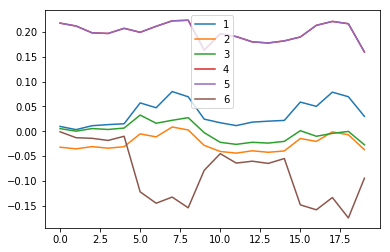

None


In [ ]:
let activationStatistics = learner.model.layerDelegates(havingType: ActivationStatistics.self)
for stats in activationStatistics {
    plt.plot(stats.activationMeans)
}
plt.legend(Array(1...activationStatistics.count))
plt.show()

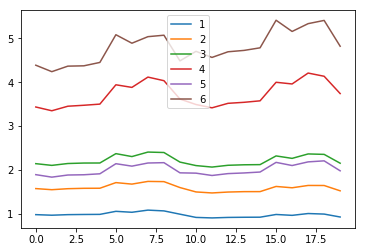

None


In [ ]:
for stats in activationStatistics {
    plt.plot(stats.activationStds)
}
plt.legend(Array(1...activationStatistics.count))
plt.show()

## Export

In [ ]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"06_cuda.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
